In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier  # Example classifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import classification_report

from sklearn.svm import SVC
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.utils import to_categorical

In [ ]:
train = pd.read_csv('/kaggle/input/attack-classification/train.csv')
test = pd.read_csv('/kaggle/input/attack-classification/test.csv')

 1. pkSeqID: Row Identifier
 2. proto: Textual representation of transaction protocols present in network flow          
 3. saddr: Source IP Address
 4. sport: Source Port Number
 5. daddr: Destination IP Address
 6. dport: Destination Port Number
 7. seq: Argus sequence number
 8. stddev: Standard deviation of aggregated records
 9. N_IN_Conn_P_SrcIP: Number of inbound connections per source IP.
 10. min: Minimum duration of aggregated records
 11. state_number: Numerical representation of feature state
 12. mean: Average duration of aggregated records
 13. N_IN_Conn_P_DstIP: Number of inbound connections per destination IP.
 14. srate: Source-to-destination packets per second
 15. drate: Destination-to-source packets per second
 16. max: Maximum duration of aggregated records
 17. attack: Class label 0 for Normal traffic, 1 for Attack Traffic
 18. category (Target Column): Traffic category
 19. subcategory: Traffic subcategory**

# **preprocessing**

In [ ]:
train.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,udp,192.168.100.150,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.0,0.494549,4.031619,1,DDoS,UDP
1,2432264,tcp,192.168.100.150,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.0,0.256493,4.012924,1,DDoS,TCP
2,1976315,tcp,192.168.100.147,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.0,0.294880,3.609205,1,DDoS,TCP
3,1240757,udp,192.168.100.150,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.0,0.461435,4.942302,1,DoS,UDP
4,3257991,udp,192.168.100.147,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.0,1.002999,4.994452,1,DDoS,UDP


In [ ]:
test.head()

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,792371,udp,192.168.100.150,48516,192.168.100.3,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1,DoS,UDP
1,2056418,tcp,192.168.100.148,22267,192.168.100.3,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1,DDoS,TCP
2,2795650,udp,192.168.100.149,28629,192.168.100.3,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1,DDoS,UDP
3,2118009,tcp,192.168.100.148,42142,192.168.100.3,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1,DDoS,TCP
4,303688,tcp,192.168.100.149,1645,192.168.100.5,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1,DoS,TCP


# dropping pkseqid and seq bcz it is just a row identifier
# drooping subcategory bcz we are dealing with categoery

In [ ]:
train.drop(["pkSeqID","seq","subcategory"], axis=1, inplace=True)
test.drop(["pkSeqID","seq","subcategory"], axis=1, inplace=True)
train.dtypes[train.dtypes=='object']

proto       object
saddr       object
sport       object
daddr       object
dport       object
category    object
dtype: object

# dropping theft category as we dont need it

In [ ]:
drop_theft = train[train['category']=='Theft'].index
train.drop(drop_theft , inplace=True)
drop_theft = test[test['category']=='Theft'].index
test.drop(drop_theft , inplace=True)

In [ ]:
train['category'].unique()
train['category'].value_counts()

category
DDoS              385271
DoS               330310
Reconnaissance     18026
Normal                84
Name: count, dtype: int64

# finding hexa numbers in sport(port number) and replacing them with decimal equalivalent

In [ ]:
search_string='0x'
result = set([i for i in train['sport'] if i.startswith(search_string)])
result

train['sport']=train['sport'].replace(['0x0303'],'771')
train['sport']=train['sport'].replace(['0x0011'],'17')
train['sport']=train['sport'].replace(['0x000d'],'13')
train['sport']=train['sport'].replace(['0x0008'],'8')

In [ ]:
test['sport']=test['sport'].replace(['0x0303'],'771')
test['sport']=test['sport'].replace(['0x0011'],'17')
test['sport']=test['sport'].replace(['0x000d'],'13')
test['sport']=test['sport'].replace(['0x0008'],'8')

In [ ]:
train["sport"] = train["sport"].astype(str).astype(int)
test["sport"] = test["sport"].astype(str).astype(int)

In [ ]:
search_string='0x'
result = set([i for i in train['dport'] if i.startswith(search_string)])
print(len(result))


876


In [ ]:
train['dport']=train.dport.apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))
train['dport'].value_counts()

dport
80       714936
1          1329
3306        914
53           66
25           44
          ...  
6361          1
29300         1
885           1
5824          1
581           1
Name: count, Length: 4038, dtype: int64

In [ ]:
test['dport'] = test.dport.apply(lambda x: int(x,16) if len(x)>1 and x[1]=="x" else int(x))

# **----------------------------Feature Engineering-----------------------------**

# making some extra features for deep analysis


In [ ]:
# Calculate frequency of source IP addresses
train['saddr_freq'] = train.groupby('saddr')['saddr'].transform('count')

# Calculate frequency of destination IP addresses
train['daddr_freq'] = train.groupby('daddr')['daddr'].transform('count')

# Display the first few rows to check the new features
print(train[['saddr', 'saddr_freq', 'daddr', 'daddr_freq']].head())


             saddr  saddr_freq          daddr  daddr_freq
0  192.168.100.150      177954  192.168.100.3      475033
1  192.168.100.150      177954  192.168.100.3      475033
2  192.168.100.147      190370  192.168.100.3      475033
3  192.168.100.150      177954  192.168.100.3      475033
4  192.168.100.147      190370  192.168.100.3      475033


In [ ]:
# Calculate frequency of source ports
train['sport_freq'] = train.groupby('sport')['sport'].transform('count')

# Calculate frequency of destination ports
train['dport_freq'] = train.groupby('dport')['dport'].transform('count')

# Display the first few rows to check the new features
print(train[['sport', 'sport_freq', 'dport', 'dport_freq']].head())


   sport  sport_freq  dport  dport_freq
0   6551          11     80      714936
1   5532           8     80      714936
2  27165           7     80      714936
3  48719           9     80      714936
4  22461          11     80      714936


In [ ]:
# Calculate the number of unique source IPs connecting to each destination IP
unique_src_per_dest = train.groupby('daddr')['saddr'].nunique().reset_index()
unique_src_per_dest.columns = ['daddr', 'unique_src_per_dest']
train = train.merge(unique_src_per_dest, on='daddr', how='left')

# Calculate the number of unique destination IPs connected by each source IP
unique_dest_per_src = train.groupby('saddr')['daddr'].nunique().reset_index()
unique_dest_per_src.columns = ['saddr', 'unique_dest_per_src']
train = train.merge(unique_dest_per_src, on='saddr', how='left')

# Display the first few rows to check the new features
print(train[['saddr', 'unique_dest_per_src', 'daddr', 'unique_src_per_dest']].head())


             saddr  unique_dest_per_src          daddr  unique_src_per_dest
0  192.168.100.150                   11  192.168.100.3                    6
1  192.168.100.150                   11  192.168.100.3                    6
2  192.168.100.147                    9  192.168.100.3                    6
3  192.168.100.150                   11  192.168.100.3                    6
4  192.168.100.147                    9  192.168.100.3                    6


In [ ]:
# Calculate duration range
train['duration_range'] = train['max'] - train['min']

# Calculate duration ratio
train['duration_ratio'] = train['mean'] / train['max']

print(train[['duration_range', 'duration_ratio']].head())

   duration_range  duration_ratio
0        4.031619        0.666610
1        0.155994        0.980564
2        0.635105        0.925807
3        4.942302        0.652091
4        2.014457        0.797529


In [ ]:
train.head()

,proto,saddr,sport,daddr,dport,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,...,attack,category,saddr_freq,daddr_freq,sport_freq,dport_freq,unique_src_per_dest,unique_dest_per_src,duration_range,duration_ratio
0,udp,192.168.100.150,6551,192.168.100.3,80,1.900363,100,0.000000,4,2.687519,...,1,DDoS,177954,475033,11,714936,6,11,4.031619,0.666610
1,tcp,192.168.100.150,5532,192.168.100.3,80,0.078003,38,3.856930,3,3.934927,...,1,DDoS,177954,475033,8,714936,6,11,0.155994,0.980564
2,tcp,192.168.100.147,27165,192.168.100.3,80,0.268666,100,2.974100,3,3.341429,...,1,DDoS,190370,475033,7,714936,6,9,0.635105,0.925807
3,udp,192.168.100.150,48719,192.168.100.3,80,1.823185,63,0.000000,4,3.222832,...,1,DoS,177954,475033,9,714936,6,11,4.942302,0.652091
4,udp,192.168.100.147,22461,192.168.100.3,80,0.822418,100,2.979995,4,3.983222,...,1,DDoS,190370,475033,11,714936,6,9,2.014457,0.797529


In [ ]:
train.columns

Index(['proto', 'saddr', 'sport', 'daddr', 'dport', 'stddev',
       'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP',
       'drate', 'srate', 'max', 'attack', 'category', 'saddr_freq',
       'daddr_freq', 'sport_freq', 'dport_freq', 'unique_src_per_dest',
       'unique_dest_per_src', 'duration_range', 'duration_ratio'],
      dtype='object')

# Label Encoding  as ML model don't directly use categorical varibles

In [ ]:
test["saddr_enc"]= le.fit_transform(test.saddr)
test["daddr_enc"]= le.fit_transform(test.daddr)
test["proto_enc"]= le.fit_transform(test.proto)
test["category_enc"]= le.fit_transform(test.category)
test.drop(['saddr','daddr','proto','category'], axis=1, inplace=True)

In [ ]:
y_train=train["category_enc"]
y_test=test["category_enc"]

In [ ]:
scaler=StandardScaler()
features = train.iloc[:,:-1]
cols=features.columns
scaled_features= scaler.fit_transform(features)
train= pd.DataFrame(scaled_features,columns=cols)

features = test.iloc[:,:-1]
cols=features.columns
scaled_features= scaler.fit_transform(features)
test= pd.DataFrame(scaled_features,columns=cols)

# **-----------------------------Exploratory Data Analysis---------------------**

In [ ]:
print(train.describe())


               sport          dport         stddev  N_IN_Conn_P_SrcIP  \
count  733691.000000  733691.000000  733691.000000       733691.00000   
mean    32911.845070     389.617192       0.887786           82.57814   
std     19114.479626    3310.169465       0.803291           24.35834   
min        -1.000000      -1.000000       0.000000            1.00000   
25%     16251.000000      80.000000       0.030194           69.00000   
50%     33308.000000      80.000000       0.800163          100.00000   
75%     49602.000000      80.000000       1.745080          100.00000   
max     65535.000000   65535.000000       2.496758          100.00000   

                 min   state_number           mean  N_IN_Conn_P_DstIP  \
count  733691.000000  733691.000000  733691.000000      733691.000000   
mean        1.017725       3.135674       2.231657          92.485871   
std         1.483737       1.186037       1.517242          18.119890   
min         0.000000       1.000000       0.000000

# attack category

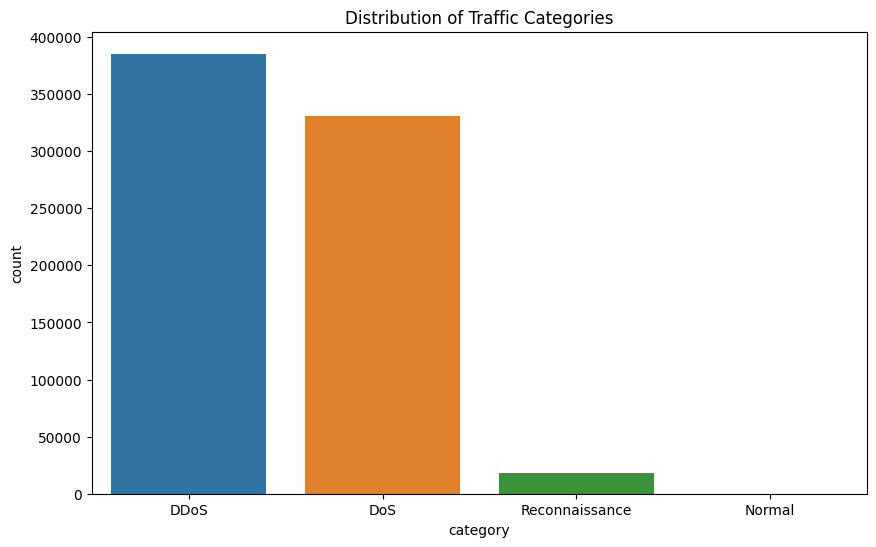

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='category', data=train)
plt.title('Distribution of Traffic Categories')
plt.show()


# 1 for attack  0 for normal

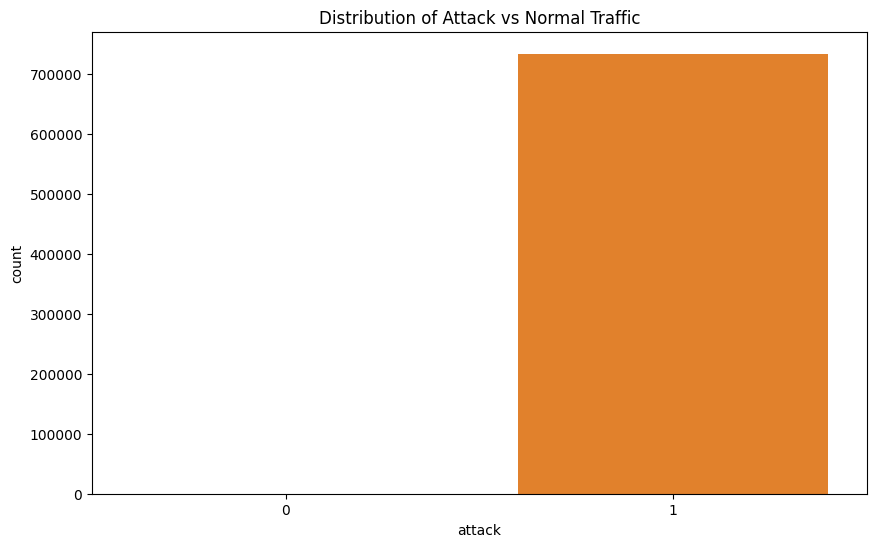

In [ ]:
# For the 'attack' column
plt.figure(figsize=(10, 6))
sns.countplot(x='attack', data=train)
plt.title('Distribution of Attack vs Normal Traffic')
plt.show()

# top 20 source ports

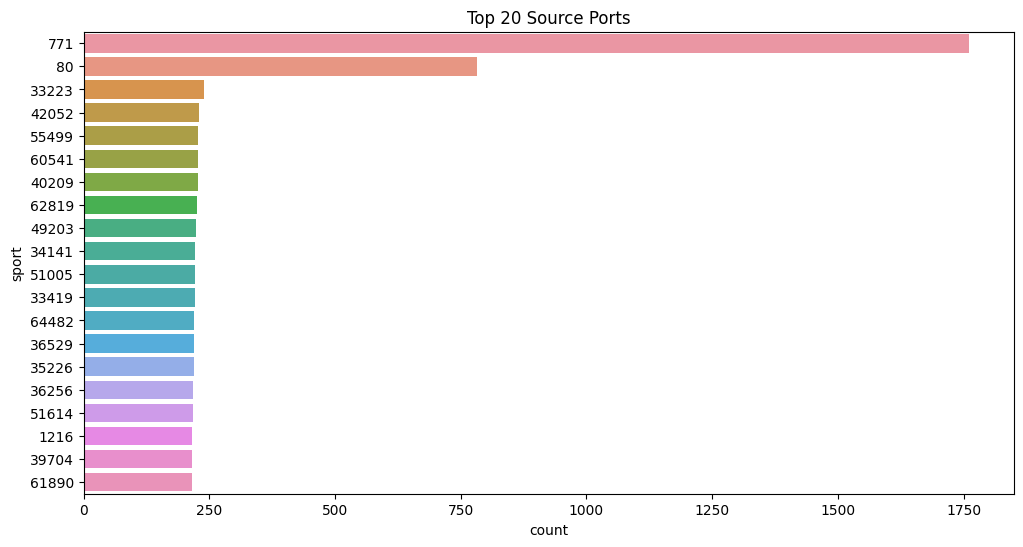

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='sport', data=train, order=train['sport'].value_counts().index[:20])
plt.title('Top 20 Source Ports')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


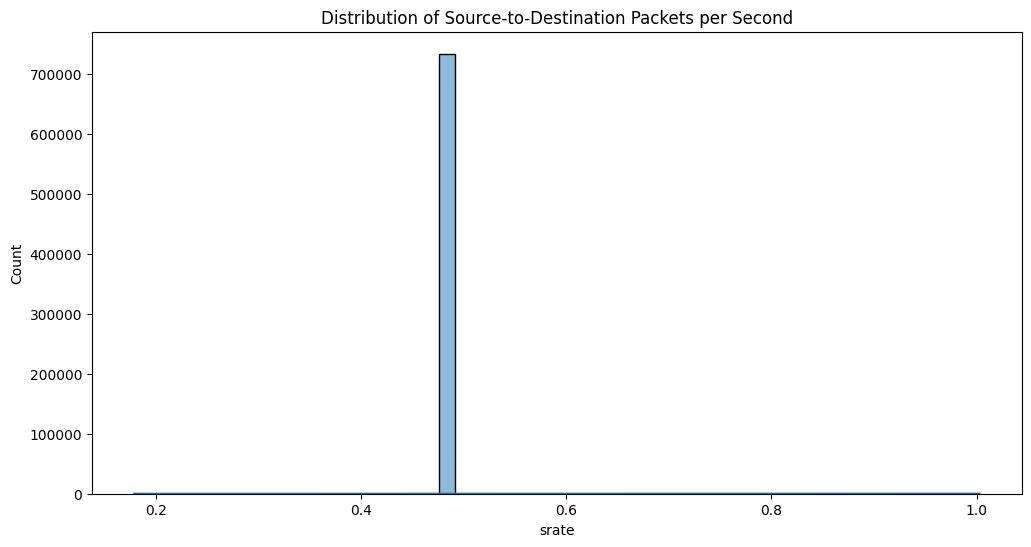

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


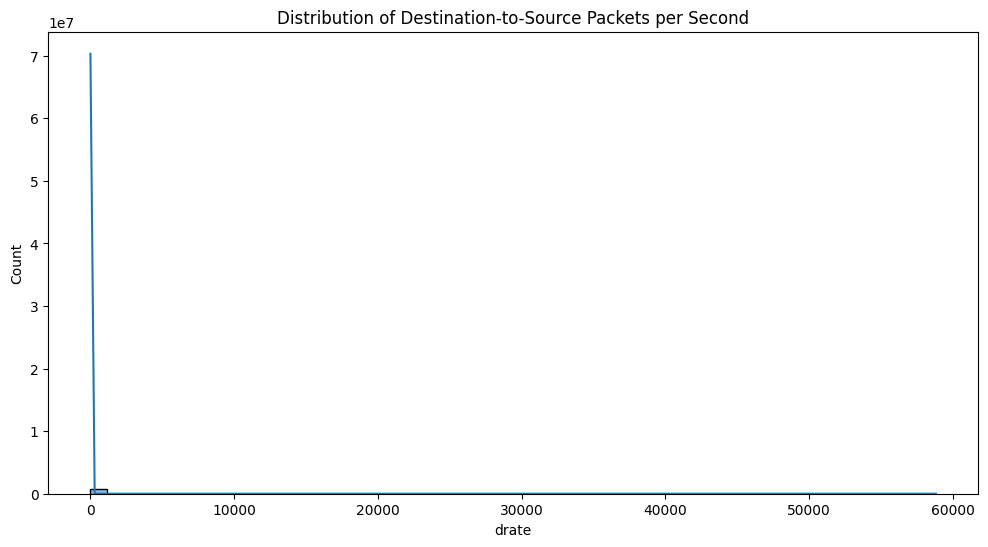

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train['srate'], bins=50, kde=True)
plt.title('Distribution of Source-to-Destination Packets per Second')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train['drate'], bins=50, kde=True)
plt.title('Distribution of Destination-to-Source Packets per Second')
plt.show()

# number of connections originating from different source and destination IP addresses

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


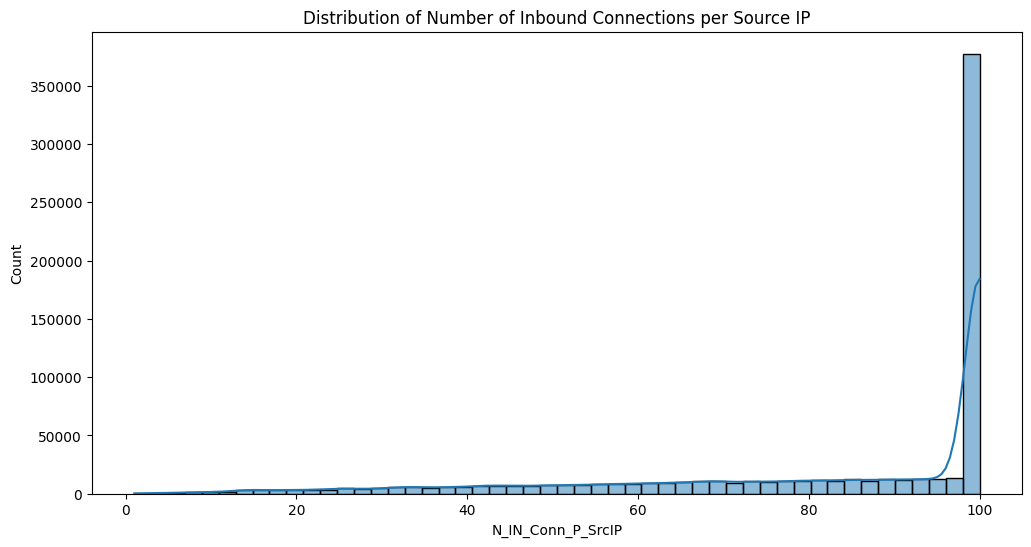

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


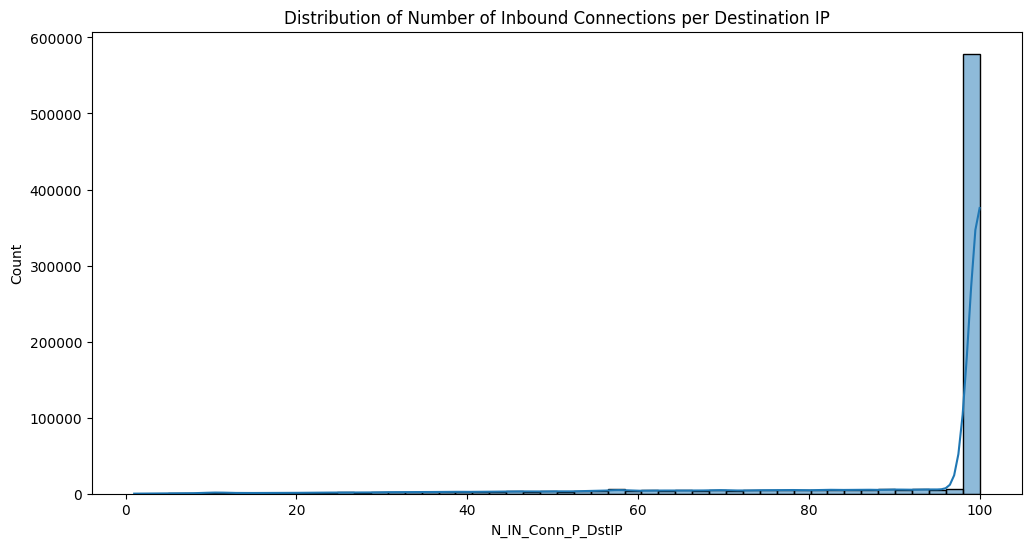

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train['N_IN_Conn_P_SrcIP'], bins=50, kde=True)
plt.title('Distribution of Number of Inbound Connections per Source IP')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train['N_IN_Conn_P_DstIP'], bins=50, kde=True)
plt.title('Distribution of Number of Inbound Connections per Destination IP')
plt.show()

# time over which the network data was collected and aggregated into a single record or flow

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


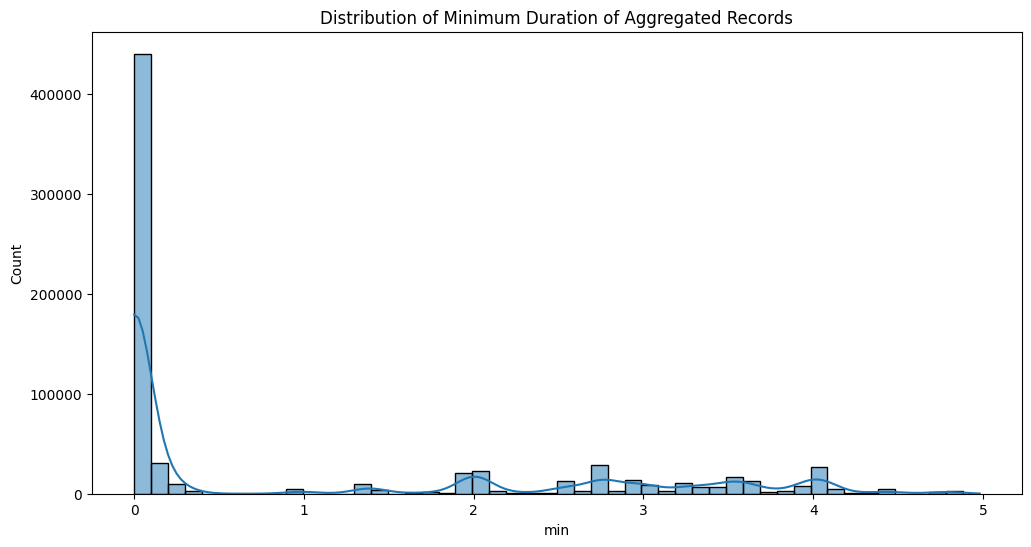

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


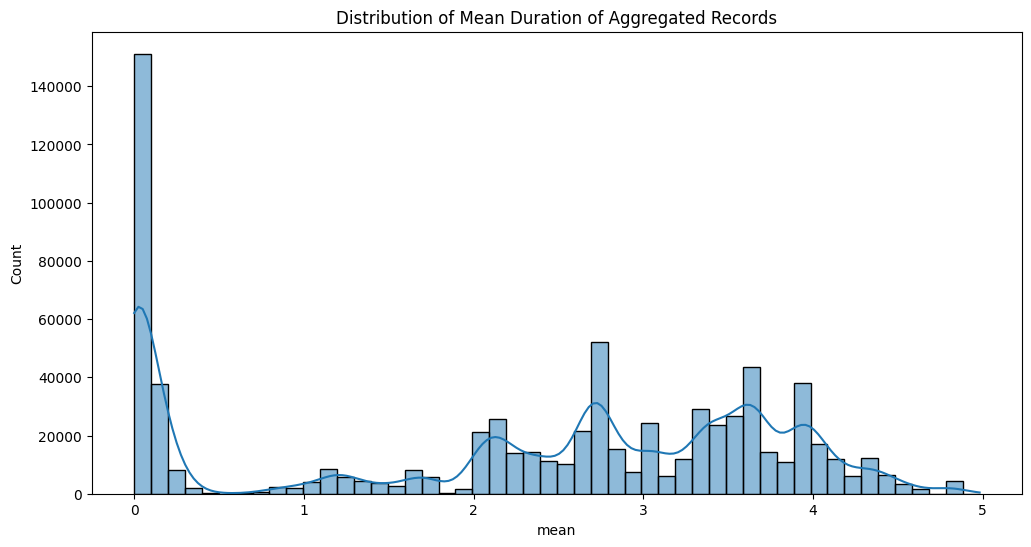

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


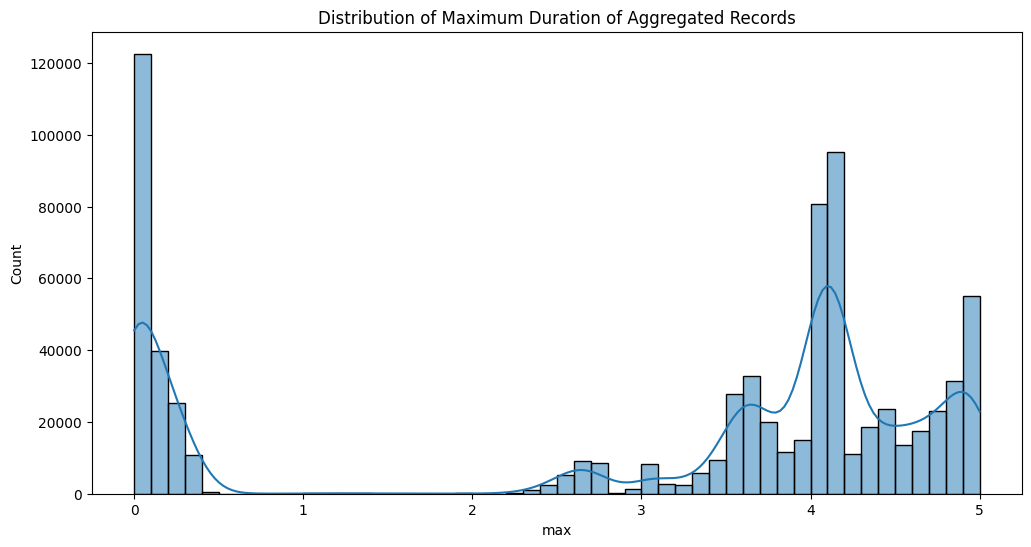

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(train['min'], bins=50, kde=True)
plt.title('Distribution of Minimum Duration of Aggregated Records')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train['mean'], bins=50, kde=True)
plt.title('Distribution of Mean Duration of Aggregated Records')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(train['max'], bins=50, kde=True)
plt.title('Distribution of Maximum Duration of Aggregated Records')
plt.show()


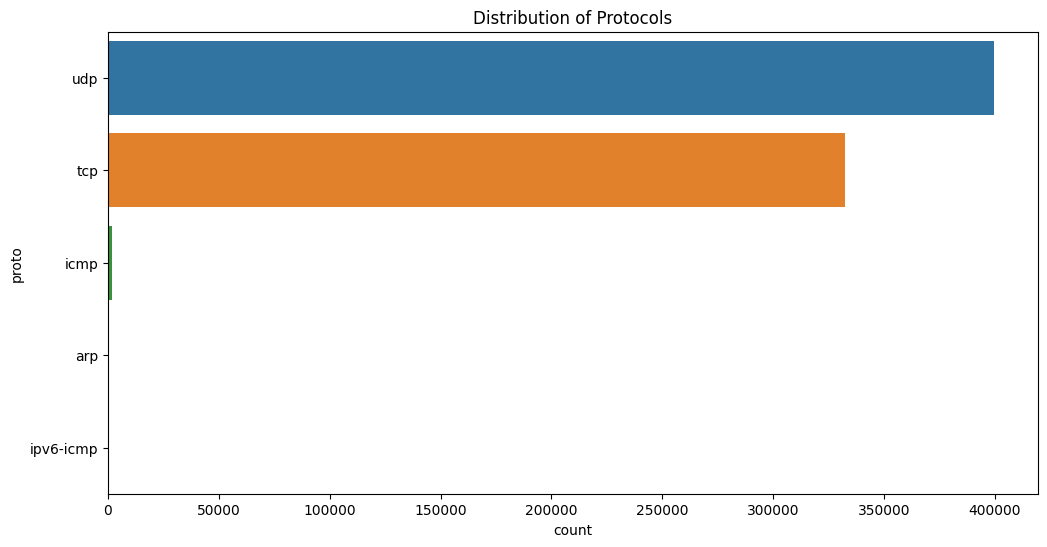

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(y='proto', data=train, order=train['proto'].value_counts().index)
plt.title('Distribution of Protocols')
plt.show()


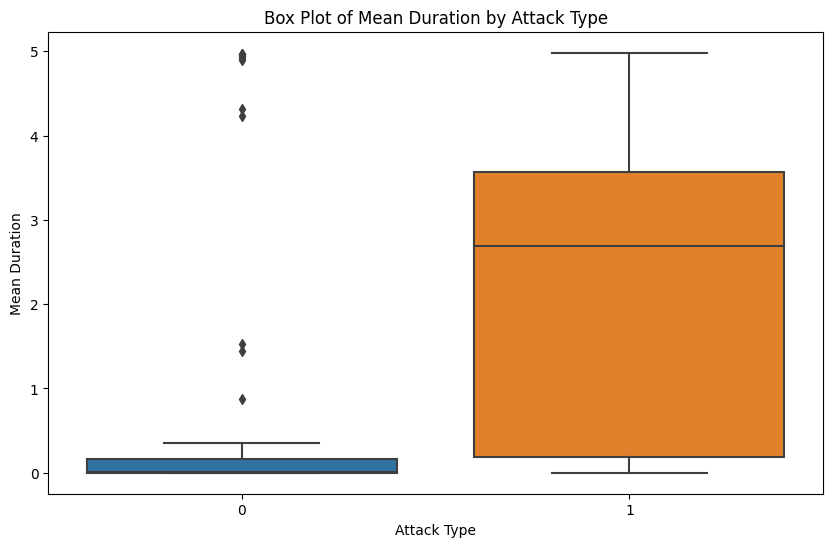

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='attack', y='mean', data=train)
plt.xlabel('Attack Type')
plt.ylabel('Mean Duration')
plt.title('Box Plot of Mean Duration by Attack Type')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

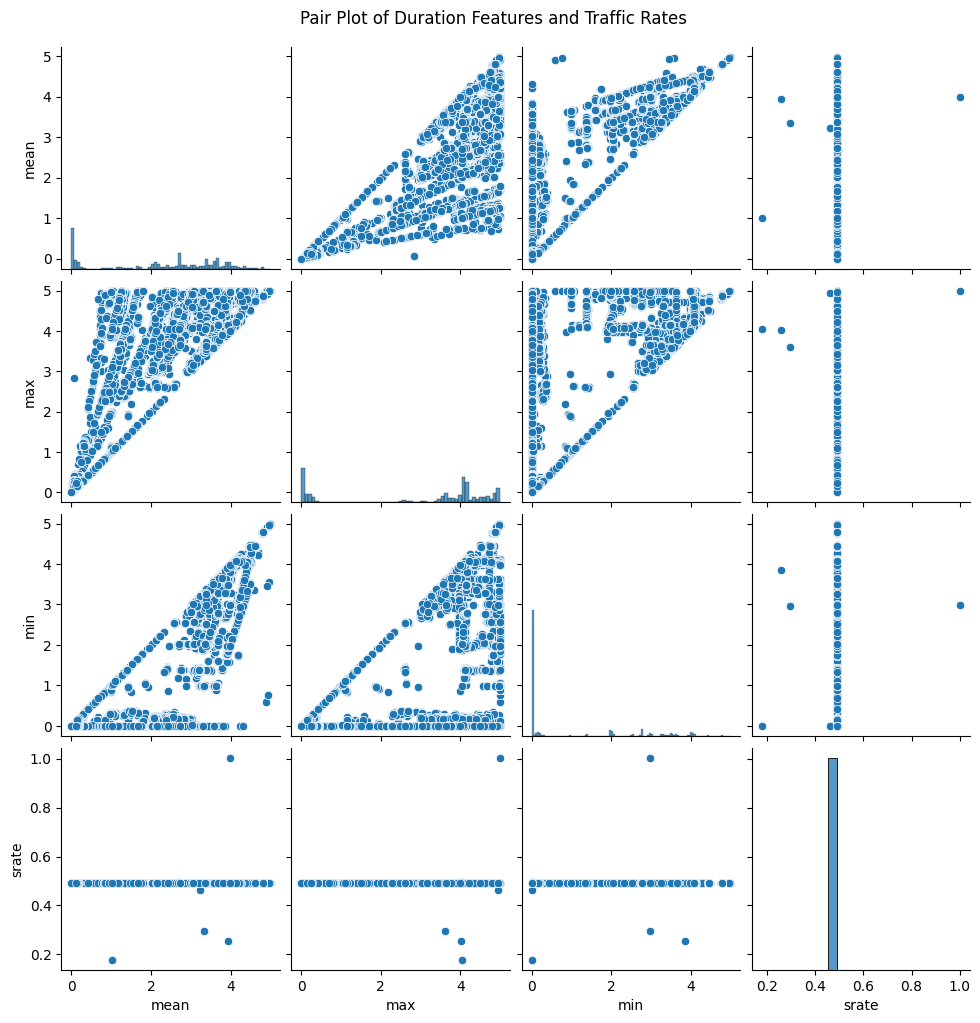

In [ ]:
sns.pairplot(train[['mean', 'max', 'min', 'srate']])
plt.suptitle('Pair Plot of Duration Features and Traffic Rates', y=1.02)
plt.show()


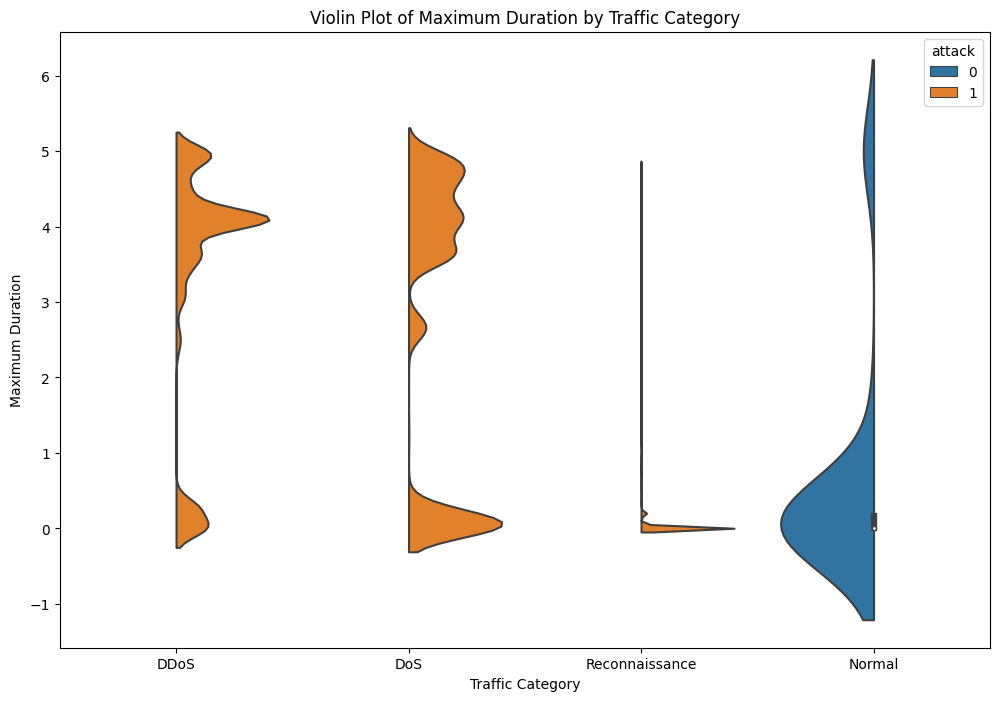

In [ ]:
plt.figure(figsize=(12, 8))
sns.violinplot(x='category', y='max', data=train, hue='attack', split=True)
plt.xlabel('Traffic Category')
plt.ylabel('Maximum Duration')
plt.title('Violin Plot of Maximum Duration by Traffic Category')
plt.show()


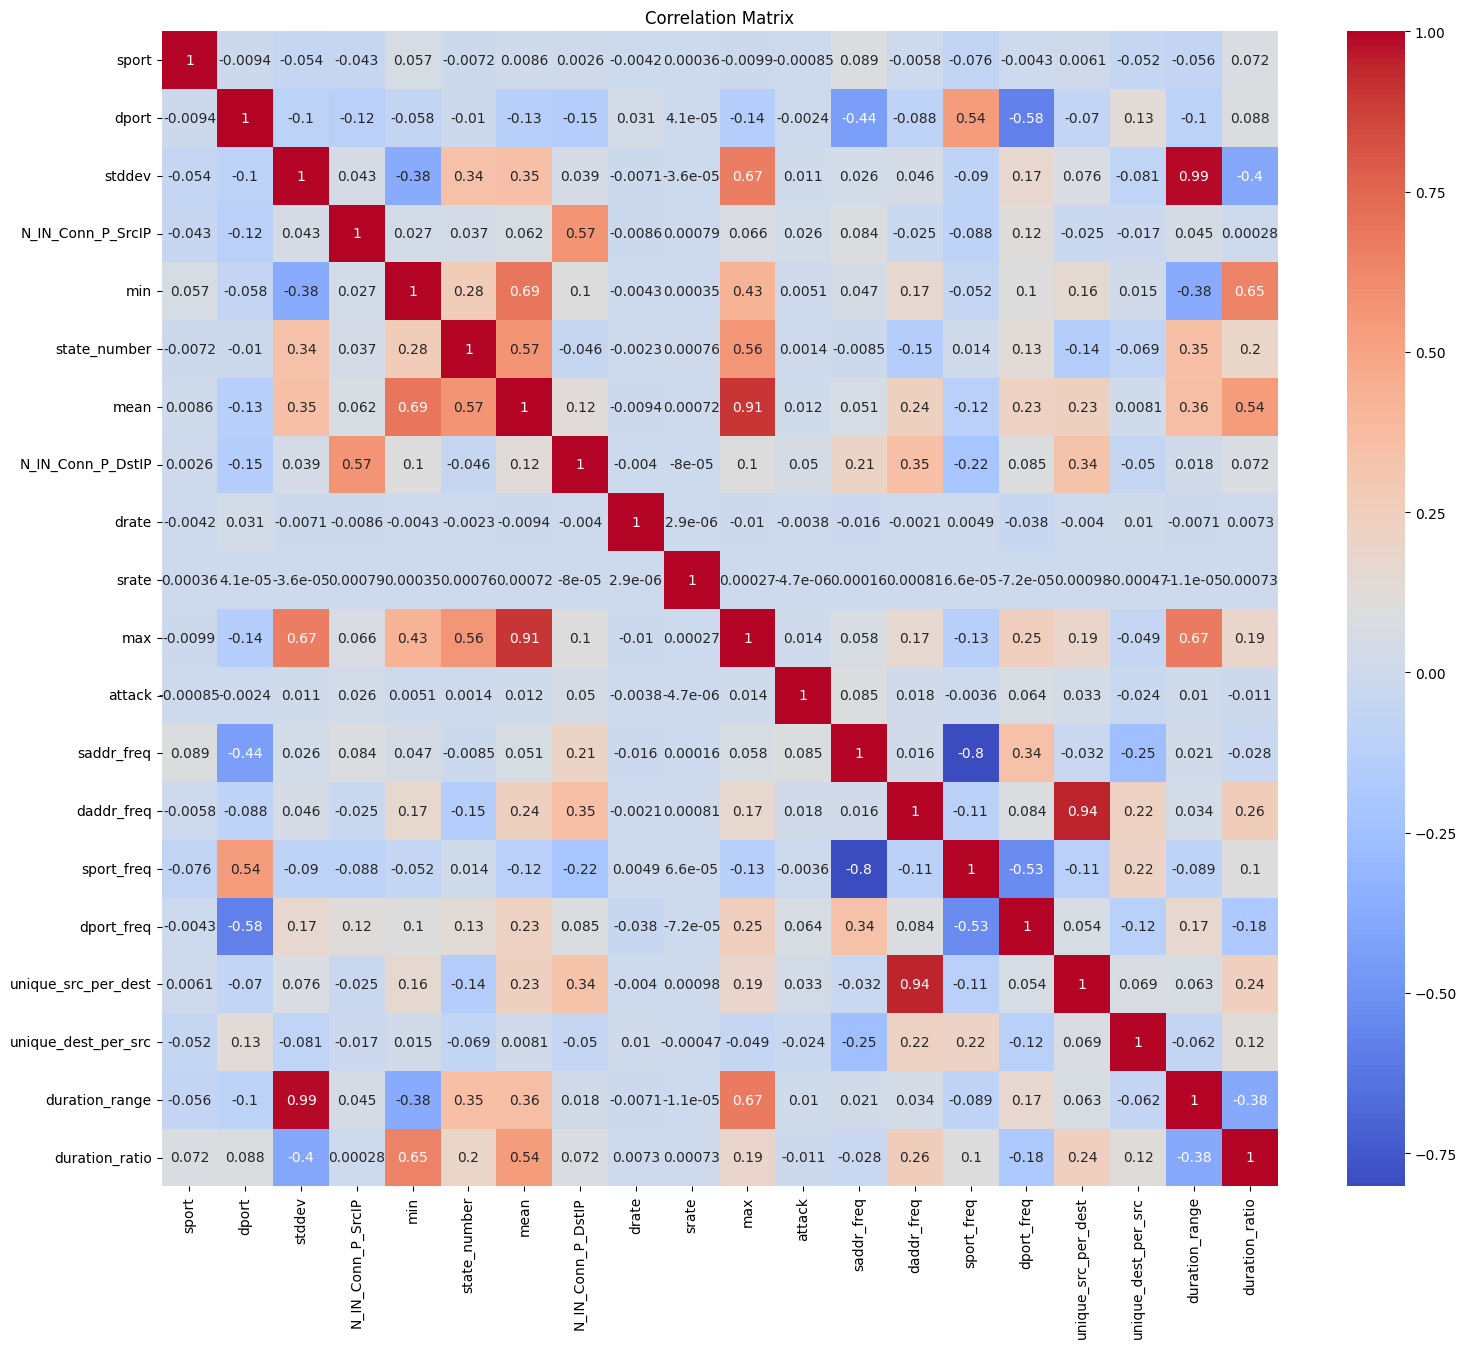

In [ ]:
numeric_columns = train.select_dtypes(include=['number'])

# Step 2: Calculate correlation matrix
correlation_matrix = numeric_columns.corr()

# Step 3: Plot heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

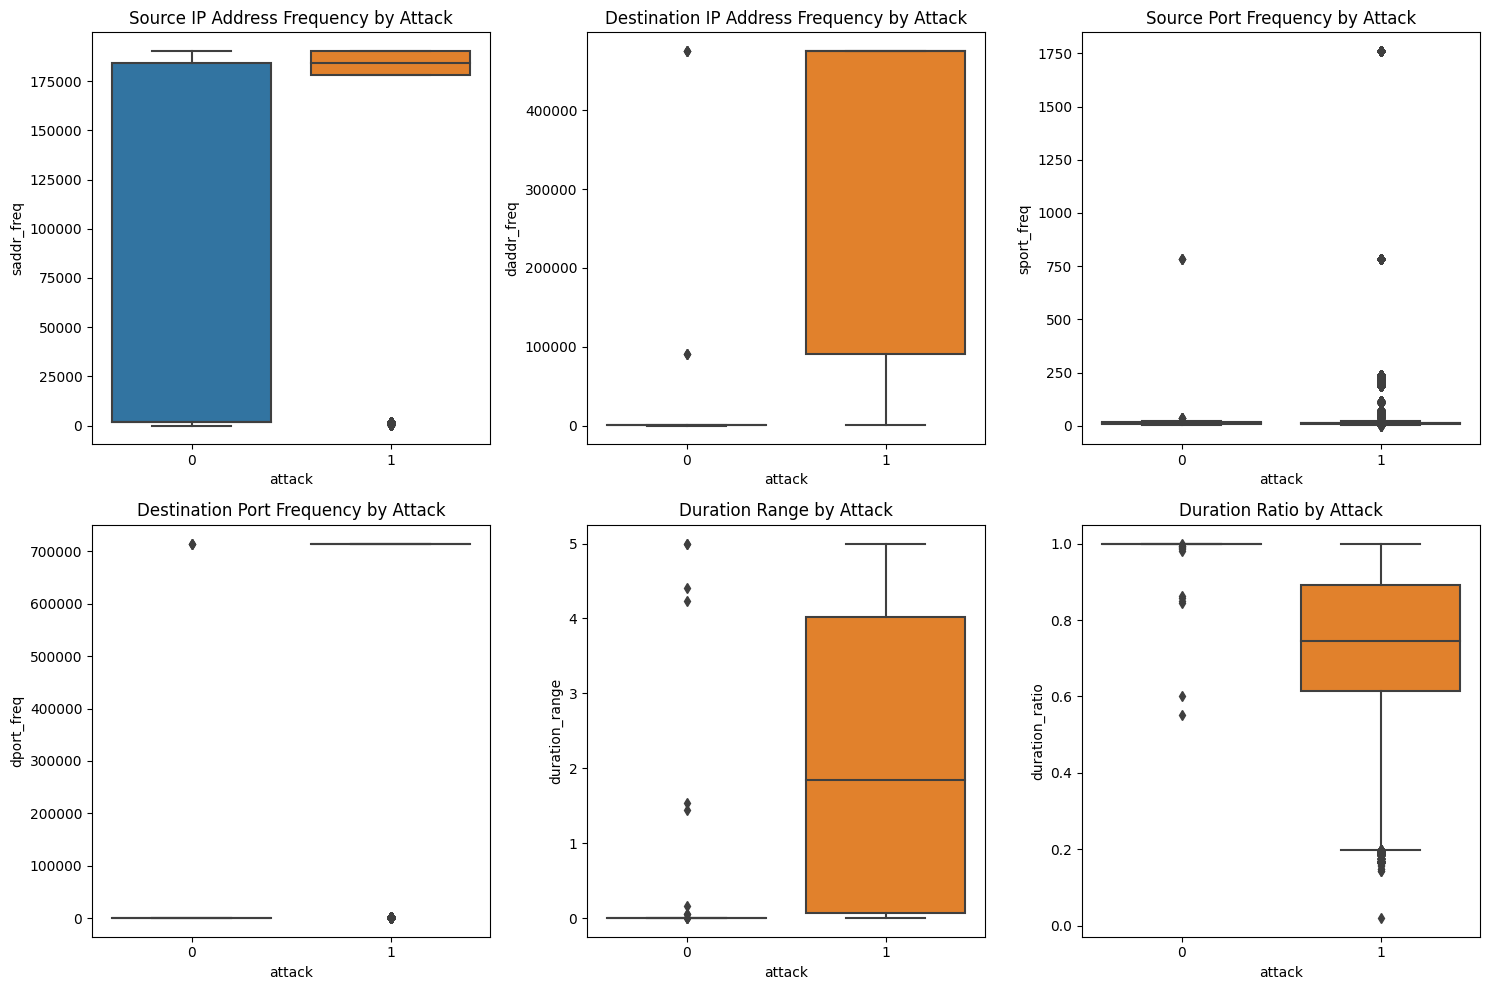

In [ ]:
# Plot box plots for new features
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
sns.boxplot(x='attack', y='saddr_freq', data=train)
plt.title('Source IP Address Frequency by Attack')

plt.subplot(2, 3, 2)
sns.boxplot(x='attack', y='daddr_freq', data=train)
plt.title('Destination IP Address Frequency by Attack')

plt.subplot(2, 3, 3)
sns.boxplot(x='attack', y='sport_freq', data=train)
plt.title('Source Port Frequency by Attack')

plt.subplot(2, 3, 4)
sns.boxplot(x='attack', y='dport_freq', data=train)
plt.title('Destination Port Frequency by Attack')

plt.subplot(2, 3, 5)
sns.boxplot(x='attack', y='duration_range', data=train)
plt.title('Duration Range by Attack')

plt.subplot(2, 3, 6)
sns.boxplot(x='attack', y='duration_ratio', data=train)
plt.title('Duration Ratio by Attack')

plt.tight_layout()
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


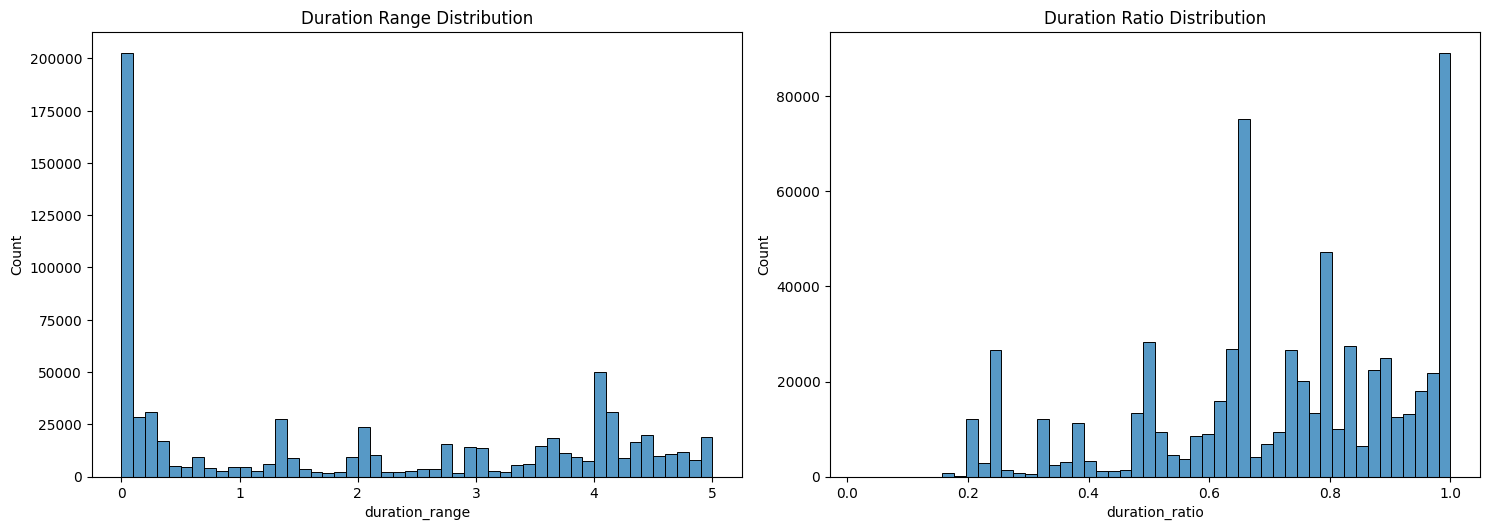

In [ ]:
# Plot the distribution of new features
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(train['duration_range'], bins=50)
plt.title('Duration Range Distribution')

plt.subplot(2, 2, 2)
sns.histplot(train['duration_ratio'], bins=50)
plt.title('Duration Ratio Distribution')

plt.tight_layout()
plt.show()


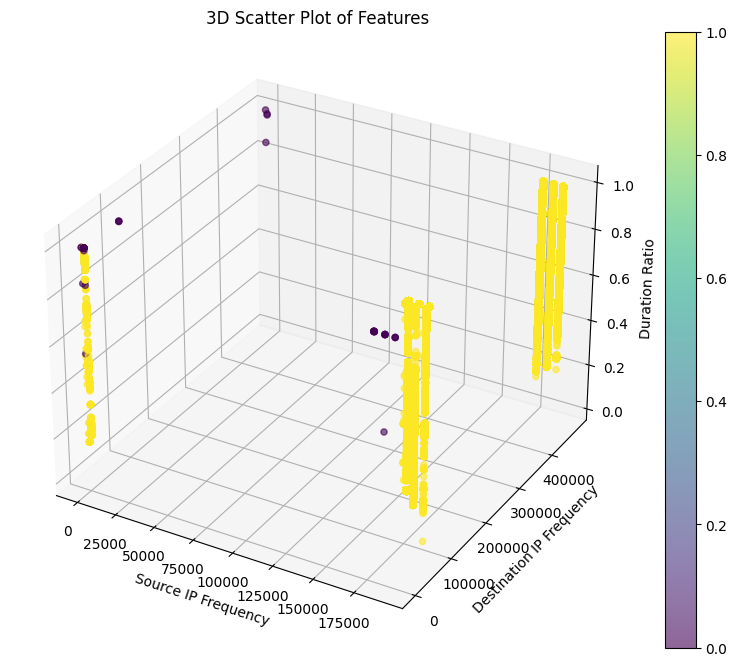

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(train['saddr_freq'], train['daddr_freq'], train['duration_ratio'], c=train['attack'], cmap='viridis', alpha=0.6)
plt.colorbar(sc)
ax.set_xlabel('Source IP Frequency')
ax.set_ylabel('Destination IP Frequency')
ax.set_zlabel('Duration Ratio')
plt.title('3D Scatter Plot of Features')
plt.show()


# hierarchical clustering with a heatmap to show which features are most similar to each other in terms of their correlation

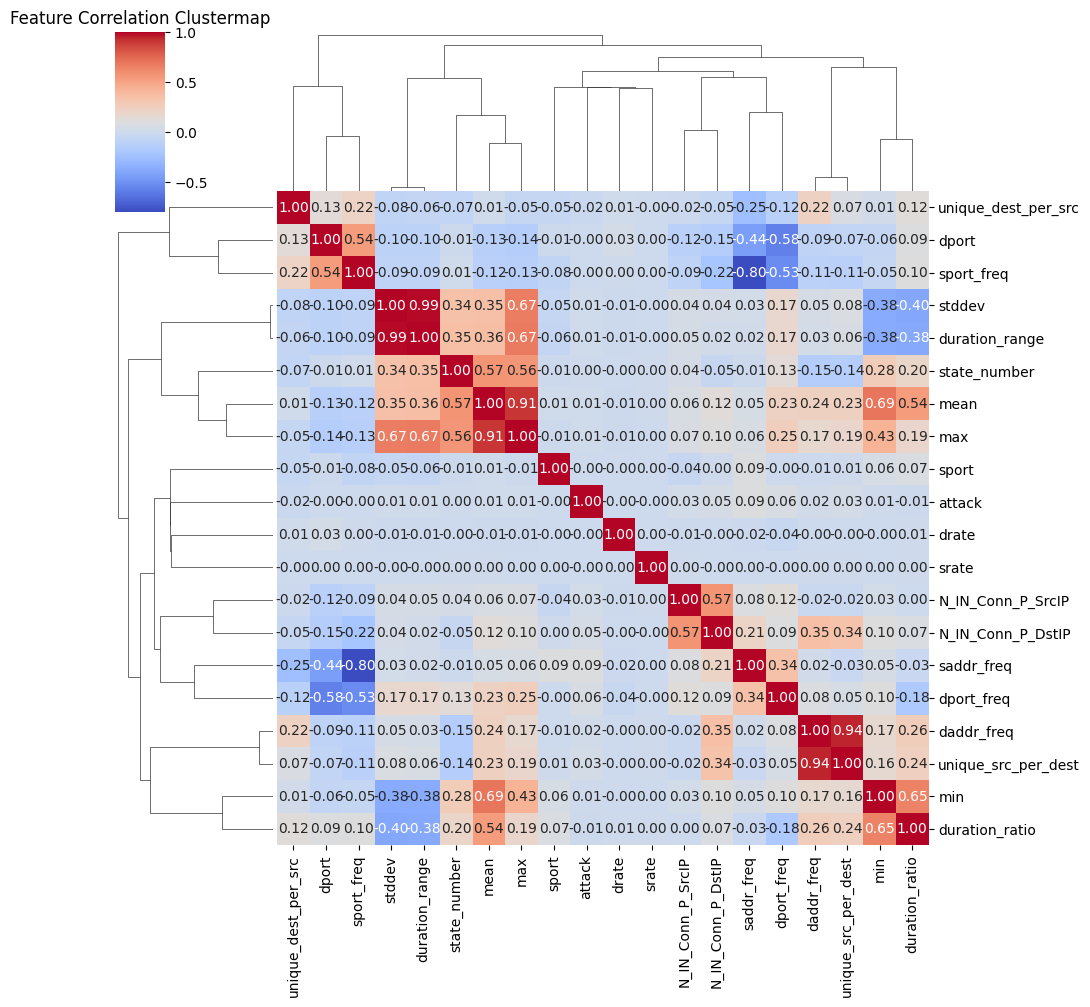

In [ ]:
train = train.select_dtypes(include=[np.number])
sns.clustermap(train.corr(), cmap='coolwarm', annot=True, fmt='.2f')
plt.title('Feature Correlation Clustermap')
plt.show()


# PCA


Explained Variance Ratio:
[0.24470761 0.11299595 0.10339126 0.0971146  0.0731243  0.06727385
 0.06599675 0.06217015 0.06004723 0.04863611]
Total explained variance: 0.9354578036831069


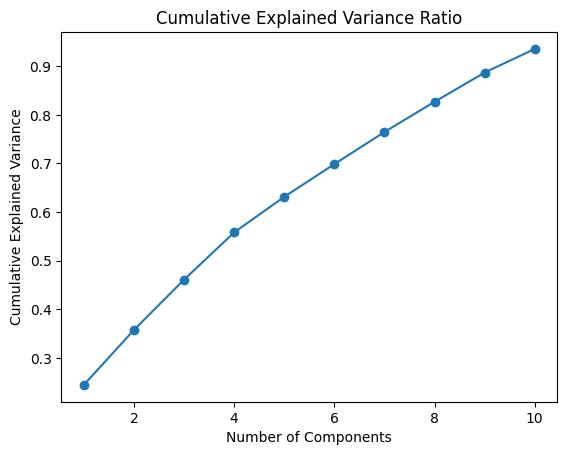

In [ ]:
# Create PCA object with desired number of components
pca = PCA(n_components=10)  # Adjust the number of components as needed

# Fit PCA on training data
pca.fit(train)
pca.fit(test)
# Transform training data
train_pca = pca.transform(train)
test_pca = pca.transform(test)

# Convert transformed data back to DataFrame (optional)
train_pca_df = pd.DataFrame(train_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
test_pca_df = pd.DataFrame(test_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])

# Optionally, print explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)
print("Total explained variance:", sum(explained_variance_ratio))

# Optionally, plot cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Ratio')
plt.show()

# RFC(Random Forest Classifier)

In [ ]:
model = RandomForestClassifier(random_state=42)

# Fit the model on PCA-transformed training data
model.fit(train_pca, y_train)

# Optionally, you can evaluate the model on training data
y_pred_train = model.predict(train_pca)
accuracy_train = accuracy_score(y_train, y_pred_train)
print("Training Accuracy:", accuracy_train)

Training Accuracy: 1.0


In [ ]:
# Predictions on training data
y_pred_train = model.predict(train_pca)

# Evaluate model performance on training data
accuracy_train = accuracy_score(y_train, y_pred_train)
precision_train = precision_score(y_train, y_pred_train, average='weighted')
recall_train = recall_score(y_train, y_pred_train, average='weighted')
f1_train = f1_score(y_train, y_pred_train, average='weighted')
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

print("Training Accuracy:", accuracy_train)
print("Training Precision:", precision_train)
print("Training Recall:", recall_train)
print("Training F1-score:", f1_train)
print("Training Confusion Matrix:")


Test Accuracy: 0.8614035063807516
Test Precision: 0.9525755015451884
Test Recall: 0.8614035063807516
Test F1-score: 0.8955888113386787
Test Confusion Matrix:


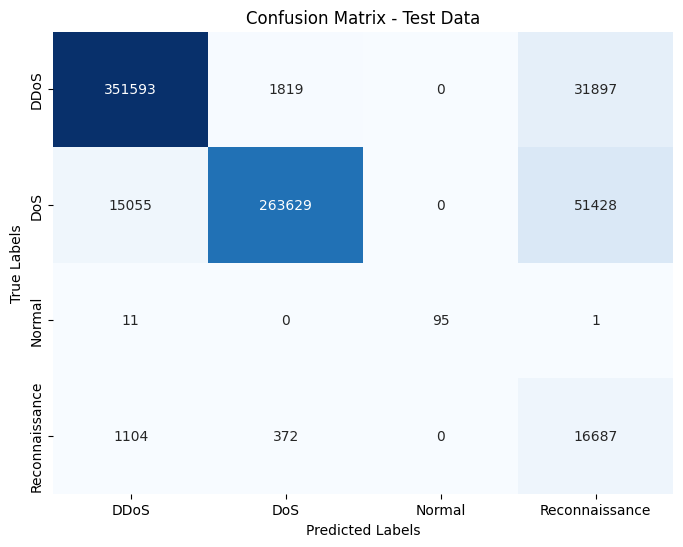

In [ ]:
labels = ['DDoS', 'DoS', 'Normal', 'Reconnaissance']
# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')
plt.show()

In [ ]:
samp_strat= { 0 : 1541315, 1 : 1320148, 2 : 72919, 3 : 72919}
random_over= RandomOverSampler(sampling_strategy=samp_strat,random_state=1)
Xres,yres = random_over.fit_resample(train,y_train)


samp_strat= { 0 : 72919, 1 : 72919, 2 : 72919, 3 : 72919}
random_under= RandomUnderSampler(sampling_strategy=samp_strat,random_state=1)
Xres1,yres1 = random_under.fit_resample(Xres,yres)


samp_strat= { 0 : 385309, 1 : 330112, 2 : 330112, 3 : 330112}
random_over_1= RandomOverSampler(sampling_strategy=samp_strat,random_state=1)
test,y_test = random_over_1.fit_resample(test,y_test)

samp_strat= { 0 : 14584, 1 : 14584, 2 : 14584, 3 : 14584}
random_over_2= RandomUnderSampler(sampling_strategy=samp_strat,random_state=1)
test,y_test = random_over_2.fit_resample(test,y_test)

In [ ]:
pd.Series(yres1)
pd.Series(y_test)
pd.Series(y_test)

176043     0
261488     0
129778     0
571791     0
197613     0
          ..
1228099    3
1348303    3
1349535    3
1138755    3
1140880    3
Name: category_enc, Length: 58336, dtype: int64

# data prepration for LSTM and RNN

In [ ]:
n_samples, n_feats = Xres1.shape[0], Xres1.shape[1]
Xres1=np.array(Xres1)
Xres1 = Xres1.reshape((n_samples, n_feats, 1))
yres1=np.array(yres1)
yres1 = to_categorical(yres1, 4)

n_samples, n_feats = test.shape[0], test.shape[1]
test=np.array(test)
test = test.reshape((n_samples, n_feats, 1))
y_test=np.array(y_test)
y_test = to_categorical(y_test, 4)


# **-------------------------LSTM------------------------**

In [ ]:
model = Sequential()
model.add(LSTM(n_feats, input_shape=(n_feats, 1)))
model.add(Dense(20))
model.add(Dense(60))
model.add(Dense(80))
model.add(Dense(90))
model.add(Dense(4, activation='softmax'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 20)             │           340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 60)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 80)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,286 (59.71 KB)

 Trainable params: 15,286 (59.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(Xres1, yres1,batch_size=256,
                                    epochs=10,
                                    validation_data=(test, y_test))

Epoch 1/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7757 - loss: 0.8173 - val_accuracy: 0.9998 - val_loss: 0.0035
Epoch 2/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9999 - loss: 9.3170e-04 - val_accuracy: 1.0000 - val_loss: 9.2210e-05
Epoch 3/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 4.5890e-05 - val_accuracy: 1.0000 - val_loss: 3.0230e-05
Epoch 4/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 1.7077e-05 - val_accuracy: 1.0000 - val_loss: 1.6080e-05
Epoch 5/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 1.0221e-05 - val_accuracy: 1.0000 - val_loss: 1.1019e-05
Epoch 6/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 7.1751e-06 - val_accuracy: 1.0000 - val_loss: 7.9893e-06
Epoch 7/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 1.0000 - loss: 5.2871e-06 - val_accuracy: 1.0000 - val_loss: 7.0730e-06
Epoch 8/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Predictions on test data
y_pred_prob = model.predict(test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluate model performance on test data
accuracy_test = accuracy_score(y_true, y_pred)
precision_test = precision_score(y_true, y_pred, average='weighted')
recall_test = recall_score(y_true, y_pred, average='weighted')
f1_test = f1_score(y_true, y_pred, average='weighted')
conf_matrix_test = confusion_matrix(y_true, y_pred)

print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1-score:", f1_test)
print("Test Confusion Matrix:\n", conf_matrix_test)

1823/1823 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Test Confusion Matrix:
 [[14584     0     0     0]
 [    0 14584     0     0]
 [    0     0 14584     0]
 [    0     0     0 14584]]


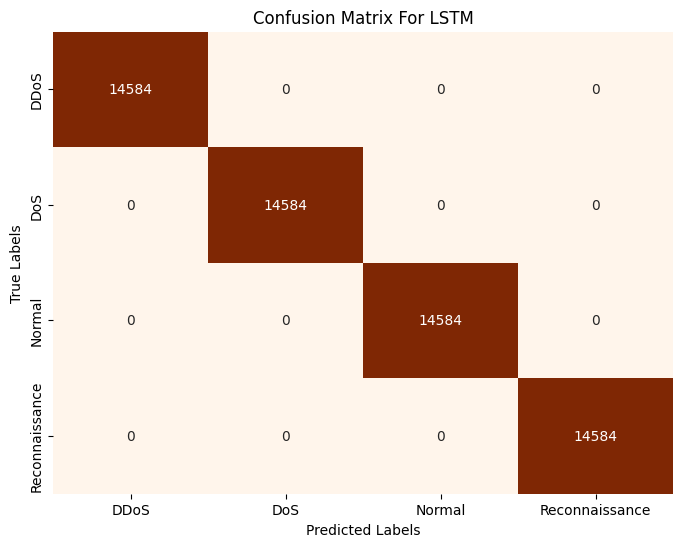

In [ ]:
# Plot confusion matrix
labels = ['DDoS', 'DoS', 'Normal', 'Reconnaissance']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For LSTM')
plt.show()

# **-----------------------------RNN---------------------------**

In [ ]:
rnn = Sequential()
rnn.add(SimpleRNN(n_feats, input_shape=(n_feats, 1)))
rnn.add(Dense(20))
rnn.add(Dense(60))
rnn.add(Dense(80))
rnn.add(Dense(90))
rnn.add(Dense(4, activation='softmax'))

opt = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
rnn.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
rnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 60)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 80)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 90)             │         7,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           364 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,422 (56.34 KB)

 Trainable params: 14,422 (56.34 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = rnn.fit(Xres1, yres1,batch_size=256,
                                    epochs=10,
                                    validation_data=(test, y_test))

Epoch 1/10
  54/1140 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3497 - loss: 1.2990    

I0000 00:00:1716754061.377839     119 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1140/1140 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8883 - loss: 0.3870 - val_accuracy: 1.0000 - val_loss: 7.7543e-05
Epoch 2/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 4.6702e-05 - val_accuracy: 1.0000 - val_loss: 2.4086e-05
Epoch 3/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 1.6731e-05 - val_accuracy: 1.0000 - val_loss: 1.3725e-05
Epoch 4/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 9.8843e-06 - val_accuracy: 1.0000 - val_loss: 9.4938e-06
Epoch 5/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 6.9732e-06 - val_accuracy: 1.0000 - val_loss: 7.1519e-06
Epoch 6/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 5.9676e-06 - val_accuracy: 1.0000 - val_loss: 5.7971e-06
Epoch 7/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 4.0278e-06 - val_accuracy: 1.0000 - val_loss: 4.8626e-06
Epoch 8/10
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms

In [ ]:
# Predictions on test data
y_pred_prob = rnn.predict(test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Evaluate model performance on test data
accuracy_test = accuracy_score(y_true, y_pred)
precision_test = precision_score(y_true, y_pred, average='weighted')
recall_test = recall_score(y_true, y_pred, average='weighted')
f1_test = f1_score(y_true, y_pred, average='weighted')
cm = confusion_matrix(y_true, y_pred)

print("Test Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1-score:", f1_test)
print("Test Confusion Matrix:\n", conf_matrix_test)

1823/1823 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1-score: 1.0
Test Confusion Matrix:
 [[14584     0     0     0]
 [    0 14584     0     0]
 [    0     0 14584     0]
 [    0     0     0 14584]]


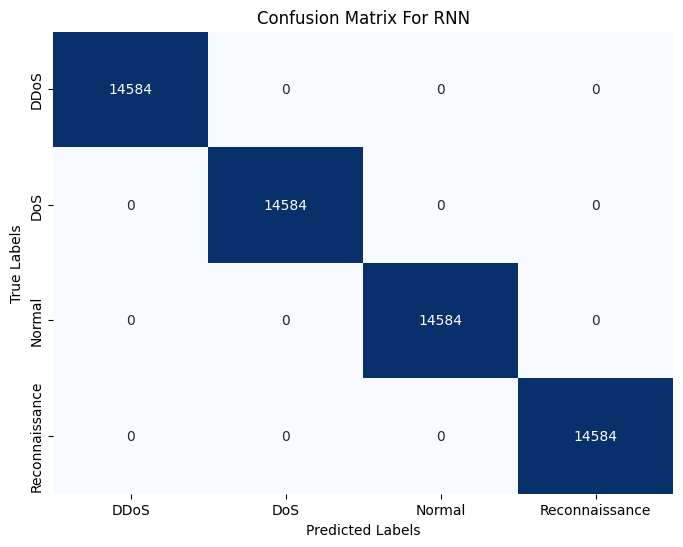

In [ ]:
labels = ['DDoS', 'DoS', 'Normal', 'Reconnaissance']

# Plot confusion matrix for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix For RNN')
plt.show()

# MODEL EVALUATION COMPARISON

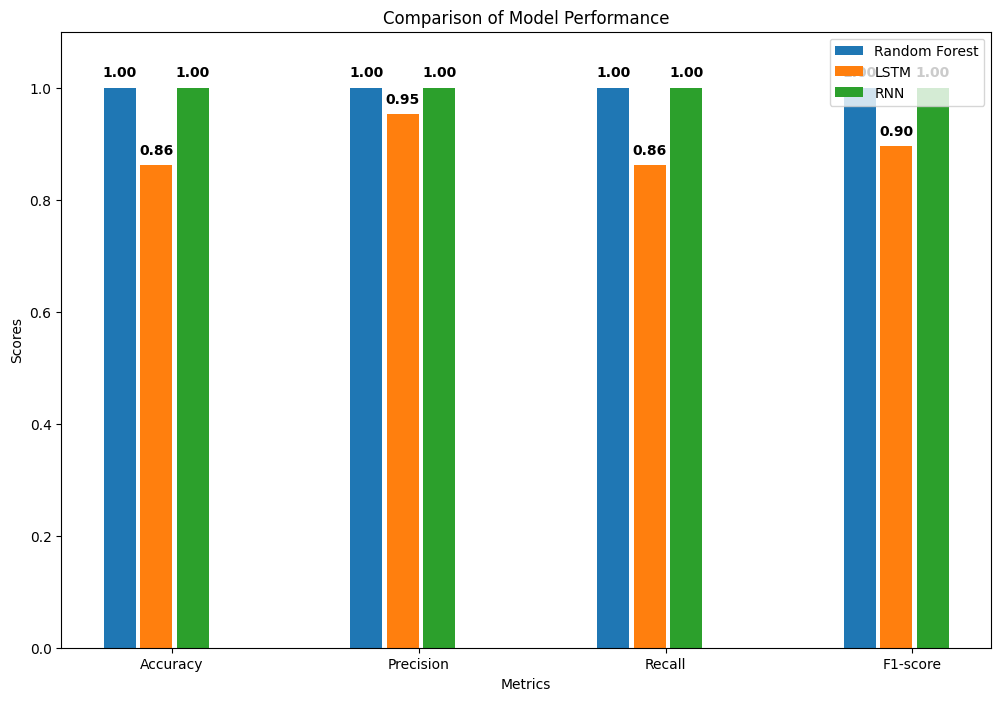

In [ ]:
metrics_rf = [1.0, 1.0, 1.0, 1.0]
metrics_lstm = [0.8614, 0.9526, 0.8614, 0.8956]
metrics_rnn = [1.0, 1.0, 1.0, 1.0]

# Combine the metrics into a list of lists
metrics = [metrics_rf, metrics_lstm, metrics_rnn]

# List of model names and metric names
model_names = ['Random Forest', 'LSTM', 'RNN']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']


num_models = len(model_names)
num_metrics = len(metric_names)


bar_width = 0.07
group_spacing = 0.5  # Space between groups of bars (different metrics)
inner_spacing = 0.01  # Space between bars within the same group (same metric)
model_offset = 0.3  # Additional space between bars of different models

# Calculate x positions
x = np.arange(num_metrics) * (num_models * (bar_width + inner_spacing) + model_offset) + group_spacing

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Add bars for each model
for i in range(num_models):
    ax.bar(x + i * (bar_width + inner_spacing), metrics[i], width=bar_width, label=model_names[i])

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Model Performance')
ax.set_xticks(x + (num_models * (bar_width + inner_spacing) - inner_spacing) / 2)
ax.set_xticklabels(metric_names)
ax.legend()

# Annotate the bars with the metric values
for i in range(num_models):
    for j in range(num_metrics):
        ax.text(x[j] + i * (bar_width + inner_spacing), metrics[i][j] + 0.02, f'{metrics[i][j]:.2f}', ha='center', fontweight='bold')

# Show the plot
plt.ylim(0, 1.1)
plt.show()
